In [5]:
import sys; sys.path.append('..'); from wwa import *
cproj = cartopy.crs.PlateCarree()

xn, xx, yn, yx = [-85,-75,6,10]
Xn, Xx, Yn, Yx = [-85,-75,5,15]

units = {"pr" : "mm/day", "tasmin" : "degC", "tasmax" : "degC"}

---
---
# Observational datasets

---
## CHIRPS

In [ ]:
chirps = xr.open_mfdataset("../../00_WWA_project_folder/live/data/chirps_05/*.nc").sel(longitude = slice(xn,xx), latitude = slice(yn, yx)).rename("pr", latitude = "lat", longitude = "lon")
chirps.to_netcdf("data/chirps05_panama.nc")

In [ ]:
chirps = xr.open_dataset("data/chirps05_panama.nc")

# daily & monthly time series
chirps_ts = chirps.mean(["lat", "lon"])
chirps_ts.to_netcdf("data/chirps_panama_ts.nc")
chirps_ts.resample(time = "MS").mean().to_netcdf("data/pr_monthly_chirps.nc")

# monthly maps
chirps = chirps.resample(time = "MS").sum()
chirps = chirps.where(chirps.sum("time") > 0)
chirps.to_netcdf("data/chirps05_panama_monthly.nc")

In [148]:
bci_px = {"lon" : -79.838234, "lat" : 9.163114}
gamboa_px = {"lon" : -79.693889, "lat" : 9.112222}
chirps.sel(time = slice(None, "2023")).sel(lon = bci_px["lon"], lat = bci_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_chirps-bci.nc")
chirps.sel(time = slice(None, "2023")).sel(lon = gamboa_px["lon"], lat = gamboa_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_chirps-gamboa.nc")

## MSWEP/MSWX

### Compile

In [ ]:
# cut out yearly slices
for y in range(2024, 1978, -1)[:2]:
    
    new_fnm = "mswep/mswep_panama_"+str(y)+".nc"
    if os.path.exists(new_fnm): continue
    
    print(y)
    da = xr.open_mfdataset("../../00_WWA_project_folder/live/data/mswep_*/"+str(y)+"*.nc").sel(lon = slice(xn,xx), lat = slice(yx, yn))
    wrap_lon(da).rename(precipitation = "pr").to_netcdf(new_fnm)

# compile into single file
xr.open_mfdataset("mswep/mswep_panama_*.nc").to_netcdf("data/mswep_panama.nc")

In [ ]:
varnm = "tmin"

# cut out yearly slices
for y in range(2024, 1978, -1):
    
    new_fnm = "mswep/mswx_"+varnm+"_panama_"+str(y)+".nc"
    if os.path.exists(new_fnm): continue
    
    print(y)
    da = xr.open_mfdataset("../00_WWA_project_folder/live/data/mswx/"+varnm+"_*/"+str(y)+"*.nc").sel(lon = slice(xn,xx), lat = slice(yx, yn))
    wrap_lon(da).rename(air_temperature = varnm).to_netcdf(new_fnm)

# compile into single file
xr.open_mfdataset("mswep/mswx_"+varnm+"_panama_*.nc").to_netcdf("data/mswx_"+varnm+"_panama.nc")

### Extract time series

In [3]:
mswep = xr.open_dataset("data/mswep_panama.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn, yx))

# land surface only
mswep = mswep.where(regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(mswep.lon, mswep.lat).squeeze(drop = True))

# daily & monthly time series
mswep_ts = mswep.mean(["lat", "lon"])
mswep_ts.to_netcdf("data/mswep_panama_ts.nc")
mswep_ts.resample(time = "MS").mean().to_netcdf("data/pr_monthly_mswep.nc")

# monthly maps
mswep = mswep.resample(time = "MS").sum()
mswep = mswep.where(mswep.sum("time") > 0)
mswep.to_netcdf("data/mswep_panama_monthly.nc")

In [50]:
vnm = "tmin"

mswx = xr.open_dataset("data/mswx_"+vnm+"_panama.nc")[vnm].sel(lon = slice(xn,xx), lat = slice(yn, yx))

# land surface only
mswx = mswx.where(regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(mswx.lon, mswx.lat).squeeze(drop = True))

# daily & monthly time series
mswx_ts = mswx.mean(["lat", "lon"])
mswx_ts.to_netcdf("data/mswx-"+vnm+"_panama_ts.nc")
mswx_ts.resample(time = "MS").mean().to_dataframe().to_csv("data/mswx-"+vnm+"_ts_monthly.csv")

# monthly maps
mswx = mswx.resample(time = "MS").sum()
mswx = mswx.where(mswx.sum("time") > 0)
mswx.to_netcdf("data/mswx-"+vnm+"_panama_monthly.nc")

In [149]:
bci_px = {"lon" : -79.838234, "lat" : 9.163114}
gamboa_px = {"lon" : -79.693889, "lat" : 9.112222}
mswep.sel(time = slice(None, "2023")).sel(lon = bci_px["lon"], lat = bci_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_mswep-bci.nc")
mswep.sel(time = slice(None, "2023")).sel(lon = gamboa_px["lon"], lat = gamboa_px["lat"], method = "nearest", drop = True).to_netcdf("data/pr_monthly_mswep-gamboa.nc")

### Compute PET

In [ ]:
tmin = xr.open_dataset("data/mswx_tmin_panama.nc").tmin
tmax = xr.open_dataset("data/mswx_tmax_panama.nc").tmax

In [ ]:
methods = ["BR65", "HG85", "MB05"]

# compute PET, convert to mm/day, and save for later reference
for mthd in methods:
    pet = potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = mthd)
    pet = convert_units_to(pet, "mm/day", context = "hydro").rename("pet")
    pet = pet.resample(time = "MS").sum()
    pet.to_netcdf("data/pet-"+mthd.lower()+"_mswx_panama_monthly.nc")

In [ ]:
pet = xr.open_dataset("data/pet-hg85_mswx_panama_monthly.nc").pet

rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask_3D(pet.lon, pet.lat).squeeze(drop = True)

[xr.open_dataset(fnm).pet.sel(time = slice(None, "2023")).where(rm == 1).mean(["lat", "lon"]).to_netcdf("data/pet_monthly_mswx_"+fnm[9:13]+".nc") for fnm in glob.glob("data/pet-*_mswx*.nc")]

In [110]:
bci_px = {"lon" : -79.838234, "lat" : 9.163114}
[xr.open_dataset(fnm).pet.sel(time = slice(None, "2023")).sel(lon = bci_px["lon"], lat = bci_px["lat"], method = "nearest", drop = True).to_netcdf("data/pet_monthly_mswx-bci_"+fnm[9:13]+".nc") for fnm in glob.glob("data/pet-*_mswx*.nc")]

[None, None, None]

---
## ERA5land

### Download

In [ ]:
import os
import cdsapi

c = cdsapi.Client()

for y in [str(y) for y in range(2023,1950,-1)]:
#     for m in [str(m).rjust(2, "0") for m in range(13)[1:]]:
        
        new_fnm = 'era5-land/era5land_panama_tp_'+y+'.nc'
        if os.path.exists(new_fnm): continue
        print(new_fnm)

        c.retrieve(
            'reanalysis-era5-land',
            {
                'variable': [
                    'total_precipitation',
                ],
                'year': y,
                'month': [
                    '01', '02', '03',
                    '04', '05', '06',
                    '07', '08', '09',
                    '10', '11', '12'],
                'day': [
                    '01', '02', '03',
                    '04', '05', '06',
                    '07', '08', '09',
                    '10', '11', '12',
                    '13', '14', '15',
                    '16', '17', '18',
                    '19', '20', '21',
                    '22', '23', '24',
                    '25', '26', '27',
                    '28', '29', '30', '31',
                ],
                'time': [
                    '00:00', '01:00', '02:00',
                    '03:00', '04:00', '05:00',
                    '06:00', '07:00', '08:00',
                    '09:00', '10:00', '11:00',
                    '12:00', '13:00', '14:00',
                    '15:00', '16:00', '17:00',
                    '18:00', '19:00', '20:00',
                    '21:00', '22:00', '23:00',
                ],
                'area': [
                    9.7, -80.25, 8.7,
                    -79.25,
                ],
                'format': 'netcdf',
            },
            new_fnm)
        

### Compile

In [8]:
ds = xr.open_mfdataset([fnm for fnm in glob.glob("era5-land/*.nc")]).max("expver").tp
ds = ds.resample(time = "D").sum()
ds.to_netcdf("data/era5land_panama.nc")

---
# Station data

## Panama Canal Authority sites

In [18]:
## PRIOR TO 2023 (monthly resolution) ##

# load data, create headers from first three rows
acp_pr = pd.read_excel("data/Monthly Rain_ACP_Vertical.xlsx", sheet_name = "Rain.All", header = None)
acp_pr.columns = [" ".join([re.sub("nan", "", str(n)) for n in list(r)]).strip() for k, r in acp_pr.iloc[:3].items()]

# clean empty rows
acp_pr = acp_pr.iloc[3:]
acp_pr = acp_pr.loc[~acp_pr.Year.isna()]

# index by date & select columns of interest
acp_pr.index = [datetime.strptime(str(int(r["Year"])) + "-" +str(int(r["Month"])), "%Y-%m") for k,r in acp_pr.iterrows()]
acp_pr = acp_pr[[c for c in acp_pr.columns if not c in ["Year", "Month", "Yr.Mon", "Average", "1-yr", "3-yr", "5-year Running Average"]]]

# modify column names to match station data
acp_pr = acp_pr.rename(columns = {"CAÑO" : "CANO",
                                  "HODGESHILL GOLD HILL" : "GOLD HILL",
                                  "CRISTOBAL COCOSOLO LIMONBAY" : "LIMONBAY",
                                  "MONTELIRIO" : "MONTE LIRIO",
                                  "SAN PEDRO" : "SANPEDRO",
                                  "VALLECENTRALGATUN" : "VALLEGATUN",
                                  "CERROCOCOLI" : "COCOLI",
                                  "PEDROMIGEL" : "PEDROMIGUEL"})

acp_pr.to_csv("data/pr_stations_acp_monthly.csv")

In [ ]:
acp_stations = pd.read_excel("data/Monthly_Rain_ACP_Vertical.xlsx", sheet_name = "Locations", skiprows = 1)
acp_stations.index = [str(s).strip() for s in acp_stations["STRI Name"]]

# label stations as active/inactive & clean rows
acp_stations["STATUS"] = "Active"
acp_stations.iloc[list(acp_stations["ACP Name"].values).index("Deactivated Stations"):,-1] = "Deactivated"
acp_stations = acp_stations.loc[(~acp_stations["ACP Name"].isna()) & (acp_stations["ACP Name"] != "Deactivated Stations")]

# remove duplicate stations
acp_stations = acp_stations.loc[~((acp_stations.index == "PEDROMIGUEL") & (acp_stations.STATUS == "Deactivated"))]
acp_stations = acp_stations.loc[~((acp_stations.index == "RIOPIEDRAS") & (acp_stations.STATUS == "Deactivated"))]

# relabel lat & lon
acp_stations = acp_stations.rename(columns = {"LAT (N).1" : "lat", "LONG (W).1" : "lon"})

acp_stations.to_csv("data/acp_stations.csv")

## STRI sites

### Precipitation

In [ ]:
bocas = pd.read_excel("data/Monthly summaries_Bocas.xlsx", sheet_name = "Daily_Previous", index_col = "date", parse_dates = ["date"])
bocas = bocas.rename(columns = {"Rain" : "bocas"})[["bocas"]]

celestino = pd.read_excel("data/Monthly summaries_celestino.xlsx", sheet_name = "Daily_Prev", parse_dates = [0], skiprows = 3, header = None)
celestino = celestino.rename(columns = {0: "date", 1: "celestino"})[["date", "celestino"]].set_index("date")

culebra = pd.read_excel("data/Monthly summaries_culebra.xlsx", sheet_name = "Daily_Prev", skiprows = 4, parse_dates = [0], index_col = 0)
culebra = culebra.rename(columns = {"ra_sum": "culebra"})[["culebra"]]

galeta = pd.read_excel("data/Monthly summaries_galeta.xlsx", sheet_name = "Daily_Previous", skiprows = 3, header = None, parse_dates = [0])
galeta = galeta.rename(columns = {0: "date", 1: "galeta"})[["date", "galeta"]].set_index("date")

pnm = pd.read_excel("data/Monthly summaries_PNM.xlsx", sheet_name = "Daily_Prevous", parse_dates = [0], skiprows = 3, header = None)
pnm = pnm.rename(columns = {0: "date", 1: "pnm"})[["date", "pnm"]].set_index("date")

psl = pd.read_excel("data/Monthly summaries_PSL.xlsx", sheet_name = "Daily_previous", parse_dates = [0], skiprows = 2, header = None)
psl = psl.rename(columns = {0: "date", 1: "psl"})[["date", "psl"]].set_index("date")

In [371]:
# compile & save
stri_pr = merge_byindex([bocas, celestino, culebra, galeta, pnm, psl])
stri_pr = stri_pr.dropna(axis = 0, how = "all")
stri_pr.to_csv("data/pr_stations_stri_daily.csv")

In [ ]:
# stri metadata
stn_stri = pd.DataFrame.from_dict({"bci" : {"lon" : -82.256565, "lat" : 9.351553},
                                   "bocas" : {"lon" : -82.256565, "lat" : 9.351553},
                                     "celestino" : {"lon" : 79.72656, "lat" : 9.21142},
                                     "culebra" : {"lon" : -79.528919, "lat" : 8.910718},
                                     "galeta" : {"lon" : -79.860837, "lat" : 9.402742},
                                     "pnm" : {"lon" : -79.543000, "lat" : 8.994410},
                                     "psl" : {"lon" : -79.974518, "lat" : 9.281031},}).transpose()
stn_stri.to_csv("data/stations_stri.csv")

## Station composites

In [16]:
acp = pd.read_csv("data/pr_stations_acp_monthly.csv", index_col = 0, parse_dates = [0])

acp_nmonths = acp.resample("AS-JAN").count().where(acp.resample("AS-JAN").count() > 0)

acp_sat = acp.loc[slice("1979",None)].loc[:,acp_nmonths.loc[slice("1979",None)].count(axis = 0) > 40]
acp_mid = acp.loc[slice("1970",None)].loc[:,acp_nmonths.loc[slice("1970",None)].count(axis = 0) > 50]
acp_long = acp.loc[slice("1925",None)].loc[:,acp_nmonths.loc[slice("1925",None)].count(axis = 0) > 95]

In [ ]:
# save composite means as monthly time series
acp_sat.mean(axis = 1).to_xarray().rename("pr", index = "time").to_netcdf("data/pr_monthly_acp-sat.nc")
acp_mid.mean(axis = 1).to_xarray().rename("pr", index = "time").to_netcdf("data/pr_monthly_acp-mid.nc")
acp_long.mean(axis = 1).to_xarray().rename("pr", index = "time").to_netcdf("data/pr_monthly_acp-long.nc")

In [59]:
(acp.loc[slice("1882",None), "GAMBOA"].to_xarray().rename("pr", index = "time")).to_netcdf("data/pr_monthly_acp-GAMBOA.nc")
(acp.loc[slice("1926",None), "BCI"].to_xarray().rename("pr", index = "time")).to_netcdf("data/pr_monthly_acp-BCI.nc")

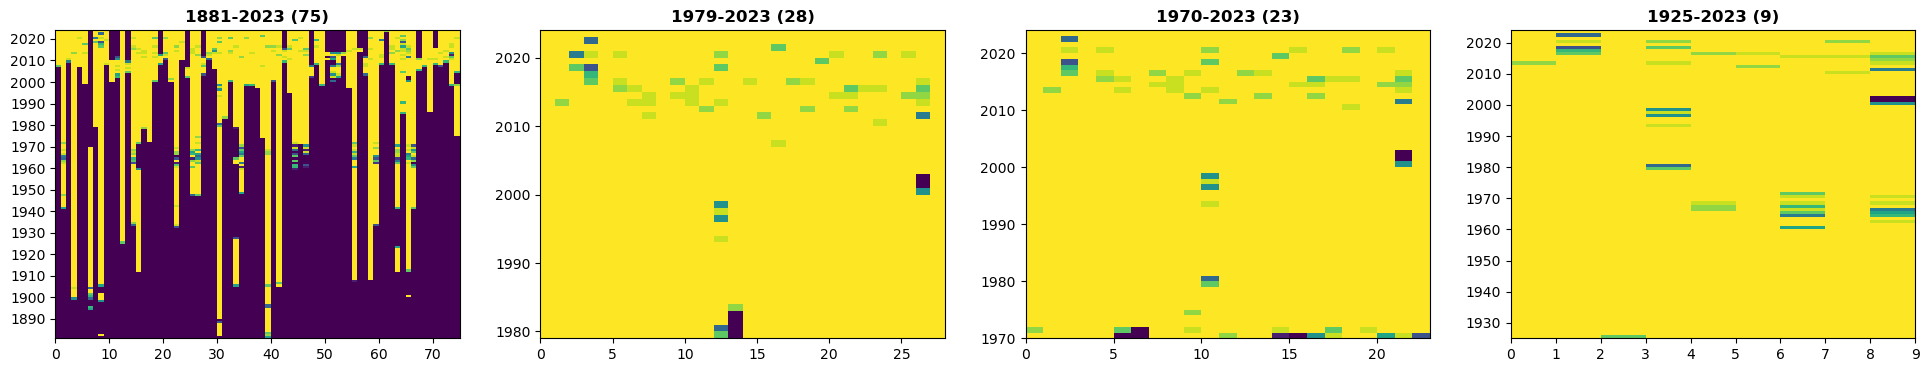

In [34]:
# how many stations are we left with when only complete stations are considered?
fig, axs = plt.subplots(ncols = 4, figsize = (24,4), dpi = 100)

for i in range(4):
    ax = axs[i]
    df = ([acp, acp_sat, acp_mid, acp_long][i]).resample("AS-JAN").count()

    ax.pcolormesh(df)
    ax.set_title(str(df.index.year.min())+"-"+str(df.index.year.max()) + " ("+str(len(df.columns))+")", fontweight = "bold")
    ax.set_yticks([df.index.year.tolist().index(y) for y in range(int(np.ceil(df.index.year.min() / 10) * 10), 2030, 10)])
    ax.set_yticklabels(range(int(np.ceil(df.index.year.min() / 10) * 10), 2030, 10))

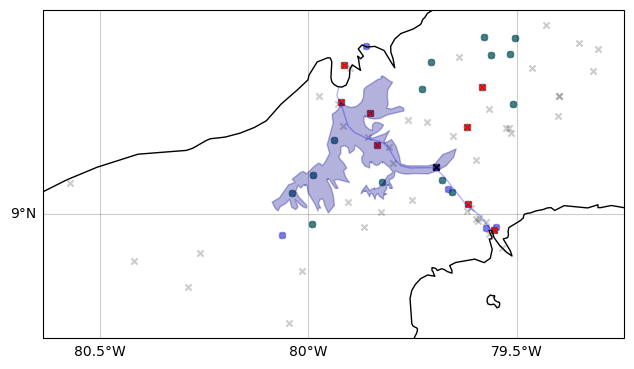

In [39]:
# which stations are we left with?
stn_data = pd.read_csv("data/acp_stations.csv", index_col = 0)

fig, ax = plt.subplots(ncols = 1, figsize = (7.5,6), dpi = 100, subplot_kw = {"projection" : cproj}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)

stn_data[["lon", "lat"]].plot(ax = ax, kind = "scatter", x = "lon", y = "lat", color = "k", alpha = 0.2, marker = "x")

stn_data.loc[acp_sat.columns, ["lon", "lat"]].plot(ax = ax, kind = "scatter", x = "lon", y = "lat", color = "blue", alpha = 0.4)
stn_data.loc[acp_mid.columns, ["lon", "lat"]].plot(ax = ax, kind = "scatter", x = "lon", y = "lat", color = "green", alpha = 0.4)
stn_data.loc[acp_long.columns, ["lon", "lat"]].plot(ax = ax, kind = "scatter", x = "lon", y = "lat", color = "red", marker = "x", facecolor = "None")
stn_data.loc[["GAMBOA"], ["lon", "lat"]].plot(ax = ax, kind = "scatter", x = "lon", y = "lat", color = "k", marker = "x", facecolor = "None")

ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.3)
ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))

<AxesSubplot: >

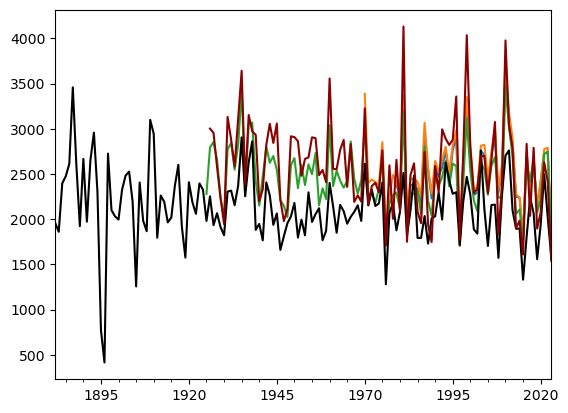

In [61]:
[ds.mean(axis = 1).resample("AS-JAN").sum().plot() for ds in [acp_sat, acp_mid, acp_long]]
acp.GAMBOA.loc[slice("1882",None)].resample("AS-JAN").sum().plot(color = "k")
acp.BCI.loc[slice("1926",None)].resample("AS-JAN").sum().plot(color = "darkred")

## Barro Colorado Island

In [62]:
# monthly precipitation
bci_pr = pd.read_excel("data/Monthly summaries_BCI_vertical.xlsx", sheet_name = "Rain_monthly", skiprows=1)
bci_pr.index = [datetime.strptime(str(r["Unnamed: 0"]) + "-" +r["Month"], "%Y-%b") for k,r in bci_pr.iterrows()]
bci_pr = bci_pr[["(mm)"]].rename(columns = {"(mm)" : "pr"})

# monthly evaporation
bci_evap = pd.read_excel("data/Monthly summaries_BCI_vertical.xlsx", sheet_name = "Evapor", skiprows=2)
bci_evap.index = [datetime.strptime(str(r["Unnamed: 0"]) + "-" +r["Unnamed: 2"], "%Y-%b") for k,r in bci_evap.iterrows()]
bci_evap = bci_evap[["(mm)", "(mm).1"]].rename(columns = {"(mm)" : "evap_claro", "(mm).1" : "evap_42m"})

# monthly temperatures - manual records (monthly mean of tmax & tmin - maxima & minima also available if needed)
bci_temps_manual = pd.read_excel("data/Monthly summaries_BCI_vertical.xlsx", sheet_name = "Temps_manual", skiprows=2)
bci_temps_manual.index = [datetime.strptime(str(r["Unnamed: 0"]) + "-" +r["Month"], "%Y-%b") for k,r in bci_temps_manual.iterrows()]
bci_temps_manual = bci_temps_manual[["Max..5", "Min..5"]].rename(columns = {"Max..5" : "tmax_manual", "Min..5" : "tmin_manual"})

# monthly temperatures - automatic records (monthly mean of tmean, tmax & tmin - maxima & minima also available if needed)
bci_temps_elec = pd.read_excel("data/Monthly summaries_BCI_vertical.xlsx", sheet_name = "Temps_elect", skiprows=2)
bci_temps_elec.index = [datetime.strptime(str(r["Unnamed: 0"]) + "-" +r["Unnamed: 2"], "%Y-%b") for k,r in bci_temps_elec.iterrows()]
bci_temps_elec = bci_temps_elec.rename(columns = {"Avg" : "tmean_elec", "Avg.1" : "tmin_elec", "Avg.2" : "tmax_elec"})[["tmean_elec", "tmin_elec", "tmax_elec"]]

bci = merge_byindex([bci_pr, bci_evap, bci_temps_manual, bci_temps_elec])
bci.to_csv("data/bci_monthly.csv")

In [ ]:
px = {"bci" : {"lon" : -79.838234, "lat" : 9.163114}}
px = pd.DataFrame(px).transpose()

In [106]:
bci_evap.evap_claro.to_xarray().rename("pet", index = "time").to_netcdf("data/pet_monthly_acp-BCI_claro.nc")
bci_evap.evap_42m.to_xarray().rename("pet", index = "time").to_netcdf("data/pet_monthly_acp-BCI_42m.nc")

---
# Climate models

## HighResMIP

### Extract subset of data

In [2]:
# list & filter models
synda_path = "/rds/general/project/wwa/ephemeral/synda_clair/data/HighResMIP/"
out_path = "/rds/general/user/cb2714/home/01_wwa/24-01_Panama-drought/highresmip/tmp/"

mdl_list = {varnm : list() for varnm in ["pr", "tasmin", "tasmax"]}

In [6]:
for fp in glob.glob(synda_path+"*/r1i1*"):
    print("_".join(fp.split("/")[-2:]))
    
    for varnm in list(mdl_list.keys()):
        
        fl = sorted(glob.glob(fp+"/"+varnm+"_*.nc"))
        print("  "+varnm+" ("+str(len(fl))+") ", end = "")
        
        if len(fl) == 0: 
            print("No data")
            continue
            
        # filter to remove any runs that don't cover the required period
        if min([fnm[-20:-16] for fnm in fl]) > "1980" or max([fnm[-11:-7] for fnm in fl]) < "2023": 
            print(str(min([fnm[-20:-16] for fnm in fl]))+"-"+str(max([fnm[-11:-7] for fnm in fl]))+" only")
            continue
            
        print("KEEP")
        mdl_list[varnm].append(fp)
      
    print("")
clear_output(wait = False)
print("Done.")

Done.


In [7]:
# extract subset of data for easier handling
for varnm in mdl_list.keys():
    ml = mdl_list[varnm]
    
    for fp in ml:
        print(fp.split("/")[-2] + " ("+str(ml.index(fp)+1)+"/"+str(len(ml))+")")
        
        fl = sorted(glob.glob(fp+"/"+varnm+"_*.nc"))
        print("  "+varnm+" ("+str(len(fl))+") ", end = "")
        
        for fnm in fl:
        
            new_fnm = out_path + re.sub("-present", "", re.sub("-future", "", fnm.split("/")[-1]))
            if os.path.exists(new_fnm): continue
                
            # if not already done, load the data & cut out the required region
            da = wrap_lon(convert_units_to(xr.open_dataset(fnm)[varnm].reset_coords(drop = True), units[varnm]))
            
            # fix dimension names if necessary
            if "longitude" in da.coords: da = da.rename(longitude = "lon", latitude = "lat")
            
            # save daily data over slightly larger region
            box = np.logical_and(np.logical_and(da.lon >= Xn, da.lon <= Xx), np.logical_and(da.lat >= Yn, da.lat <= Yx))
            box = box.where(box == 1).dropna("lon", "all").dropna("lat", "all")
            sp = da.sel({"lon" : box.lon, "lat" : box.lat})
            sp.to_netcdf(new_fnm)
            
            print(".", end = "")

        print("")
    clear_output(wait = False)
print("Done.")

Done.


### Compile into single dataset

---
## CMIP6

Downloaded via synda:
`synda search project=CMIP6 variant_label=r1i1p1f1 experiment_id='ssp585,historical' frequency=day variable='pr,tasmin,tasmax'  local_path_drs_template=CMIP6/%(source_id)s/%(variable)s`

---
## CORDEX (SAM)
_Downloaded via synda_

In [14]:
synda_path = "/rds/general/project/wwa/ephemeral/synda_clair/data/"
out_path = "/rds/general/user/cb2714/home/01_wwa/24-01_Panama-drought/cordex/tmp/"

In [58]:
# filter out any models that don't have both historical & rcp85
model_list = [m for m in sorted(glob.glob(synda_path+"*/*/*")) if not "HighResMIP" in m and not "CMIP6" in m]

mdl_list = {k : list() for k in ["pr", "tasmin", "tasmax"]}
for fp in model_list:
    for varnm in mdl_list.keys():
        fl_hist = glob.glob(fp+"/"+varnm+"/*hist*.nc")
        fl_rcp = glob.glob(fp+"/"+varnm+"/*rcp85*.nc")
        
        if len(fl_hist) == 0 or len(fl_rcp) == 0: continue
        mdl_list[varnm].append(fp)

In [77]:
abridge_gcm = {'CCCma-CanESM2' : "CanESM2",
               "CNRM-CERFACS-CNRM-CM5" : "CNRM-CM5",
               'CSIRO-QCCCE-CSIRO-Mk3-6-0' : 'CSIRO-Mk3-6-0',
               "ICHEC-EC-EARTH" : "EC-EARTH",
               'IPSL-IPSL-CM5A-LR' : 'IPSL-CM5A-LR',
               'IPSL-IPSL-CM5A-MR' : 'IPSL-CM5A-MR',
               'MIROC-MIROC5' : 'MIROC5',
               'MOHC-HadGEM2-ES' : 'HadGEM2-ES',
               'MPI-M-MPI-ESM-LR' : 'MPI-ESM-LR',
               'MPI-M-MPI-ESM-MR' : 'MPI-ESM-MR',
               'NCC-NorESM1-M' : 'NorESM1-M',
               'NOAA-GFDL-GFDL-ESM2G' : 'GFDL-ESM2G',
               'NOAA-GFDL-GFDL-ESM2M' : 'GFDL-ESM2M'}

In [104]:
# extract subset of data for easier handling
for varnm in mdl_list.keys():
    ml = mdl_list[varnm]
    
    for fp in ml:
        mdl = "_".join([abridge_gcm[fp.split("/")[-3]]] + fp.split("/")[-2:])
        print(mdl + " ("+str(ml.index(fp)+1)+"/"+str(len(ml))+")")
        
        # something wrong with time bounds in this one, can't open the files
        if mdl in ['HadGEM2-ES_r1i1p1_RegCM4-3']: continue
        
        fl = sorted(glob.glob(fp+"/"+varnm+"/"+varnm+"_*.nc"))
        print("  "+varnm+" ("+str(len(fl))+") ", end = "")
        
        for fnm in fl:
            print(".", end = "")
            new_fnm = out_path+"_".join([varnm, fnm.split("_")[2], mdl, fnm.split("_")[-1]])
            
            # skip if file has already been processed
            if os.path.exists(new_fnm): continue
            
            # load data, convert to correct units
            da = xr.open_dataset(fnm)[varnm]
            da = convert_units_to(da, units[varnm])
            if "height" in da.coords: da.reset_coords("height", drop = True)  # clean up unwanted extra coordinates
                
            # identify primary coordinates
            if "rlon" in da.dims:
                xdim, ydim = ["rlat", "rlon"]
            elif "x" in da.dims:
                xdim, ydim = ["x", "y"]
            else:
                print(da.dims)
                continue
            
            # cut out smaller region & save as temp file
            box = np.logical_and(np.logical_and(da.lon >= Xn, da.lon <= Xx), np.logical_and(da.lat >= Yn, da.lat <= Yx))
            box = box.where(box == 1).dropna(xdim, "all").dropna(ydim, "all")
            da = da.sel({xdim : box[xdim], ydim : box[ydim]})
            da.to_netcdf(new_fnm)
            
            print(".", end = "")
        print("")
    clear_output(wait = False)
print("Done.")

Done.


---
## CORDEX (CAM)
_Downloaded via synda_

In [2]:
synda_path = "/rds/general/project/wwa/ephemeral/synda_clair/data/"
out_path = "/rds/general/user/cb2714/home/01_wwa/24-01_Panama-drought/cordex/tmp/"

In [12]:
# filter out any models that don't have both historical & rcp85
model_list = [m for m in sorted(glob.glob(synda_path+"*/*/*/*")) if "CAM-" in m]
mdl_list = {k : list() for k in ["pr", "tasmin", "tasmax"]}
for fp in model_list:
    for varnm in mdl_list.keys():
        fl_hist = glob.glob(fp+"/"+varnm+"/*hist*.nc")
        fl_rcp = glob.glob(fp+"/"+varnm+"/*rcp85*.nc")
        
        if len(fl_hist) == 0 or len(fl_rcp) == 0: continue
        mdl_list[varnm].append(fp)

In [17]:
abridge_gcm = {'CCCma-CanESM2' : "CanESM2",
               "CNRM-CERFACS-CNRM-CM5" : "CNRM-CM5",
               'CSIRO-QCCCE-CSIRO-Mk3-6-0' : 'CSIRO-Mk3-6-0',
               "ICHEC-EC-EARTH" : "EC-EARTH",
               'IPSL-IPSL-CM5A-LR' : 'IPSL-CM5A-LR',
               'IPSL-IPSL-CM5A-MR' : 'IPSL-CM5A-MR',
               'MIROC-MIROC5' : 'MIROC5',
               'MOHC-HadGEM2-ES' : 'HadGEM2-ES',
               'MPI-M-MPI-ESM-LR' : 'MPI-ESM-LR',
               'MPI-M-MPI-ESM-MR' : 'MPI-ESM-MR',
               'NCC-NorESM1-M' : 'NorESM1-M',
               'NOAA-GFDL-GFDL-ESM2G' : 'GFDL-ESM2G',
               'NOAA-GFDL-GFDL-ESM2M' : 'GFDL-ESM2M'}

In [20]:
# extract subset of data for easier handling
for varnm in mdl_list.keys():
    ml = mdl_list[varnm]
    
    for fp in ml:
        mdl = "_".join([abridge_gcm[fp.split("/")[-3]]] + fp.split("/")[-2:])
        print(mdl + " ("+str(ml.index(fp)+1)+"/"+str(len(ml))+")")
        
        # something wrong with time bounds in this one, can't open the files
        if mdl in ['HadGEM2-ES_r1i1p1_RegCM4-3', 'MPI-ESM-MR_r1i1p1_RegCM4-3']: continue
        
        fl = sorted(glob.glob(fp+"/"+varnm+"/"+varnm+"_*.nc"))
        print("  "+varnm+" ("+str(len(fl))+") ", end = "")
        
        for fnm in fl:
            print(".", end = "")
            new_fnm = out_path+"_".join([varnm, fnm.split("_")[2], mdl, fnm.split("_")[-1]])
            
            # skip if file has already been processed
            if os.path.exists(new_fnm): continue
            
            # load data, convert to correct units
            da = xr.open_dataset(fnm)[varnm]
            da = convert_units_to(da, units[varnm])
            if "height" in da.coords: da.reset_coords("height", drop = True)  # clean up unwanted extra coordinates
                
            # identify primary coordinates
            if "rlon" in da.dims:
                xdim, ydim = ["rlat", "rlon"]
            elif "x" in da.dims:
                xdim, ydim = ["x", "y"]
            else:
                print(da.dims)
                continue
            
            # cut out smaller region & save as temp file
            box = np.logical_and(np.logical_and(da.lon >= Xn, da.lon <= Xx), np.logical_and(da.lat >= Yn, da.lat <= Yx))
            box = box.where(box == 1).dropna(xdim, "all").dropna(ydim, "all")
            da = da.sel({xdim : box[xdim], ydim : box[ydim]})
            da.to_netcdf(new_fnm)
            
            print(".", end = "")
        print("")
    clear_output(wait = False)
print("Done.")

Done.


### Compile

In [ ]:
glob.glob("cordex/tmp/pr*.nc")

---
# Time series for climate explorer

In [152]:
pr_ds = {"chirps" : "CHIRPS", "mswep" : "MSWEP",
            "acp-long" : "mean of long-running ACP stations", "acp-mid" : "mean of ACP stations running since 1970", "acp-sat" : "mean of ACP stations running since 1979",
            "acp-BCI" : "ACP station BCI", "acp-GAMBOA" : "ACP station GAMBOA",
            "mswep-bci" : "MSWEP BCI", "mswep-gamboa" : "MSWEP GAMBOA", "chirps-bci" : "CHIRPS BCI", "chirps-gamboa" : "CHIRPS GAMBOA"}

pet_ds = {"mswx" : "MSWX averaged over central Panama",
                "mswx-bci" : "MSWX at grid cell containing Barro Colorado Island",
                "acp-BCI" : "ACP station at Barro Colorado Island"}
pet_types = {"br65" : "Baier-Robertson", "mb05" : "McGuinness-Bordne", "hg85" : "Hargreaves", "claro" : "claro", "42m" : "42m"}

## Wet-season precip

In [153]:
for ds in [fnm[16:-3] for fnm in glob.glob("data/pr_monthly_*.nc")]:
    
    ts = xr.open_dataset("data/pr_monthly_"+ds+".nc").pr.resample(time = "MS").sum().sel(time = slice(None, "2023"))

    ts = ts.sel(time = [m > 4 for m in ts.time.dt.month.values]).resample(time = "AS-JAN").sum()    
    ts = ts.assign_coords(time = ts.time.dt.year).rename("pr", time = "year").to_dataframe()

    csv_fnm = "panama_pr-wetseason_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+pr_ds[ds]+" wet-season precipitation - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of May-December precipitation at "+csv_fnm+".dat"
    head = "# year pr"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

## Dry-season precip

In [154]:
for ds in [fnm[16:-3] for fnm in glob.glob("data/pr_monthly_*.nc")]:
    
    ts = xr.open_dataset("data/pr_monthly_"+ds+".nc").pr.resample(time = "MS").sum().sel(time = slice(None, "2023"))

    ts = ts.sel(time = [m <= 4 for m in ts.time.dt.month.values]).resample(time = "AS-JAN").sum()    
    ts = ts.assign_coords(time = ts.time.dt.year).rename("pr", time = "year").to_dataframe()

    csv_fnm = "panama_pr-dryseason_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+pr_ds[ds]+" dry-season precipitation - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of January-April precipitation at "+csv_fnm+".dat"
    head = "# year pr"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

## Dry-season PET


In [137]:
for ds in [fnm[17:-3] for fnm in glob.glob("data/pet_monthly_*.nc")]:
    
    ts = xr.open_dataset("data/pet_monthly_"+ds+".nc").pet.resample(time = "MS").sum().sel(time = slice(None, "2023"))

    ts = ts.sel(time = [m <= 4 for m in ts.time.dt.month.values]).resample(time = "AS-JAN").sum()    
    ts = ts.assign_coords(time = ts.time.dt.year).rename("pr", time = "year").to_dataframe()

    csv_fnm = "panama_pet-dryseason_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: dry-season potential evapotranspiration ("+pet_ds[ds.split("_")[0]]+", "+pet_types[ds.split("_")[1]]+") - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of January-April PET at "+csv_fnm+".dat"
    head = "# year pet"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

## Wet-season PET


In [138]:
for ds in [fnm[17:-3] for fnm in glob.glob("data/pet_monthly_*.nc")]:
    
    ts = xr.open_dataset("data/pet_monthly_"+ds+".nc").pet.resample(time = "MS").sum().sel(time = slice(None, "2023"))

    ts = ts.sel(time = [m > 4 for m in ts.time.dt.month.values]).resample(time = "AS-JAN").sum()    
    ts = ts.assign_coords(time = ts.time.dt.year).rename("pr", time = "year").to_dataframe()

    csv_fnm = "panama_pet-wetseason_"+ds
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: wet-season potential evapotranspiration ("+pet_ds[ds.split("_")[0]]+", "+pet_types[ds.split("_")[1]]+") - Panama drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr [mm] annual mean of May-December PET at "+csv_fnm+".dat"
    head = "# year pet"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)